In [31]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 15.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 3.5 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11123 sha256=30e314a7e9dbf0ae0453468b1add88d95c6f676e36196c20812efcfc23d6ed4a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3c/77

In [32]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna as op

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-3/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-3/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-3/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Replacing weird Education value
train.loc[train['Education'] == 15, 'Education'] = 5

# Random Forest Modeling

In [26]:
train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
train_dummies = train_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

X = train_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours', 'Attrition'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['Attrition']

test_dummies = pd.get_dummies(test_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
test_dummies = test_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

test_RF = test_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours'], axis = 1)
test_RF = pd.concat([test_RF, test_dummies], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        RF_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 2, n_estimators = 500).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        RF_pred_1 = RF_md.predict_proba(X_test)[:, 1]
        RF_pred_2 = RF_md.predict_proba(test_RF)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, RF_pred_1))
        preds.append(RF_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

RF_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', RF_cv_score)

The roc-auc score over 5-folds (run 5 times) is: 0.8231127834402198


# XGBoost Modeling

In [67]:
train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
train_dummies = train_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

X = train_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours', 'Attrition'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['Attrition']

X['feature_1'] = np.where(((X['StockOptionLevel'] >= 1) & (X['YearsAtCompany'] >= 3) & (X['YearsWithCurrManager'] >= 1)), 1, 0)
X['feature_2'] = np.where(((X['StockOptionLevel'] < 1) & (X['MonthlyIncome'] > 2700) & (X['OverTime_Yes'] < 1)), 1, 0) 


test_dummies = pd.get_dummies(test_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
test_dummies = test_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

test_RF = test_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours'], axis = 1)
test_RF = pd.concat([test_RF, test_dummies], axis = 1)

test_RF['feature_1'] = np.where(((test_RF['StockOptionLevel'] >= 1) & (test_RF['YearsAtCompany'] >= 3) & (test_RF['YearsWithCurrManager'] >= 1)), 1, 0)
test_RF['feature_2'] = np.where(((test_RF['StockOptionLevel'] < 1) & (test_RF['MonthlyIncome'] > 2700) & (test_RF['OverTime_Yes'] < 1)), 1, 0) 

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        XGB_md = XGBClassifier(colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 500, 
                               subsample = 0.7).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test_RF)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

XGB_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The roc-auc score over 5-folds (run 5 times) is: 0.8331698923499772


# LightGBM Modeling

In [38]:
import lightgbm as lg
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split

train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
train_dummies = train_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

X = train_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours', 'Attrition'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['Attrition']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

rskf = RepeatedStratifiedKFold(n_repeats = 5, n_splits = 5, random_state = 42)

def objective(trial):
    
    scores = []
    
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        'boosting_type': 'gbdt',
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-5, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 75),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.35, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 8),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 25),
    }
    
    for i, (train_idx, test_index) in enumerate(rskf.split(X_train, Y_train)):
        
        dtrain = lg.Dataset(X_train.iloc[train_idx], label = Y_train.iloc[train_idx])
        dval = lg.Dataset(X_train.iloc[test_index], label = Y_train.iloc[test_index])
        
        pruning_callback = op.integration.LightGBMPruningCallback(trial, metric='auc', valid_name='val')
        gbm = lg.train(params=params, train_set=dtrain, valid_sets=[dtrain, dval],
                       valid_names=['train', 'val'], num_boost_round=10_000,
                       callbacks=[lg.log_evaluation(250, show_stdv=False), lg.early_stopping(10, verbose = False),
                                 lg.print_evaluation(250, show_stdv=False), pruning_callback])
        
        pred = gbm.predict(data = X_test)
        score = roc_auc_score(Y_test, pred)
        scores.append(score)
        
    return np.mean(scores)

In [41]:
pruner = op.pruners.MedianPruner(n_startup_trials=35, n_warmup_steps=50)
sampler = op.samplers.TPESampler(multivariate=True, n_startup_trials=35)
study = op.create_study(direction="maximize", sampler=sampler, pruner=pruner)

study.optimize(objective, n_trials = 50)  


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:281: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-01-18 01:35:15,816] A new study created in memory with name: no-name-36790e90-cd8a-44be-9f3c-db10d7fb7ac0
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is de

In [42]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 50
Best trial:
  Value: 0.8226402027027028
  Params: 
    lambda_l1: 0.8575417663829832
    lambda_l2: 1.9164812147766739
    max_depth: 27
    num_leaves: 39
    feature_fraction: 0.9367127097979216
    bagging_fraction: 0.6799543571713667
    bagging_freq: 1
    min_child_samples: 22


In [68]:
train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
train_dummies = train_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

X = train_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours', 'Attrition'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['Attrition']

X['feature_1'] = np.where(((X['StockOptionLevel'] >= 1) & (X['YearsAtCompany'] >= 3) & (X['YearsWithCurrManager'] >= 1)), 1, 0)
X['feature_2'] = np.where(((X['StockOptionLevel'] < 1) & (X['MonthlyIncome'] > 2700) & (X['OverTime_Yes'] < 1)), 1, 0) 


test_dummies = pd.get_dummies(test_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
test_dummies = test_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

test_RF = test_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours'], axis = 1)
test_RF = pd.concat([test_RF, test_dummies], axis = 1)

test_RF['feature_1'] = np.where(((test_RF['StockOptionLevel'] >= 1) & (test_RF['YearsAtCompany'] >= 3) & (test_RF['YearsWithCurrManager'] >= 1)), 1, 0)
test_RF['feature_2'] = np.where(((test_RF['StockOptionLevel'] < 1) & (test_RF['MonthlyIncome'] > 2700) & (test_RF['OverTime_Yes'] < 1)), 1, 0) 

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 10,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_RF)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

# CatBoost Modeling

In [66]:
train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
train_dummies = train_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

X = train_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours', 'Attrition'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['Attrition']

X['feature_1'] = np.where(((X['StockOptionLevel'] >= 1) & (X['YearsAtCompany'] >= 3) & (X['YearsWithCurrManager'] >= 1)), 1, 0)
X['feature_2'] = np.where(((X['StockOptionLevel'] < 1) & (X['MonthlyIncome'] > 2700) & (X['OverTime_Yes'] < 1)), 1, 0) 


test_dummies = pd.get_dummies(test_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
test_dummies = test_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

test_RF = test_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours'], axis = 1)
test_RF = pd.concat([test_RF, test_dummies], axis = 1)

test_RF['feature_1'] = np.where(((test_RF['StockOptionLevel'] >= 1) & (test_RF['YearsAtCompany'] >= 3) & (test_RF['YearsWithCurrManager'] >= 1)), 1, 0)
test_RF['feature_2'] = np.where(((test_RF['StockOptionLevel'] < 1) & (test_RF['MonthlyIncome'] > 2700) & (test_RF['OverTime_Yes'] < 1)), 1, 0) 


cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building the CatBoost model
        cat_md = CatBoostClassifier(iterations = 1000, 
                                    depth = 7,
                                    learning_rate = 0.01,
                                    rsm = 0.5,
                                    subsample = 0.9,
                                    l2_leaf_reg = 69,
                                    min_data_in_leaf = 20,
                                    random_strength = 0.175,
                                    random_seed = 836,
                                    task_type = 'CPU',
                                    bootstrap_type = 'Bernoulli',
                                    grow_policy = 'SymmetricTree',
                                    loss_function = 'Logloss',
                                    verbose = False).fit(X_train, Y_train)
            
        ## Predicting on X_test and test
        cat_pred_1 = cat_md.predict_proba(X_test)[:, 1]
        cat_pred_2 = cat_md.predict_proba(test_RF)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, cat_pred_1))
        preds.append(cat_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

cat_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', cat_cv_score)

The roc-auc score over 5-folds (run 5 times) is: 0.839260364177737


# Feature Engineering 

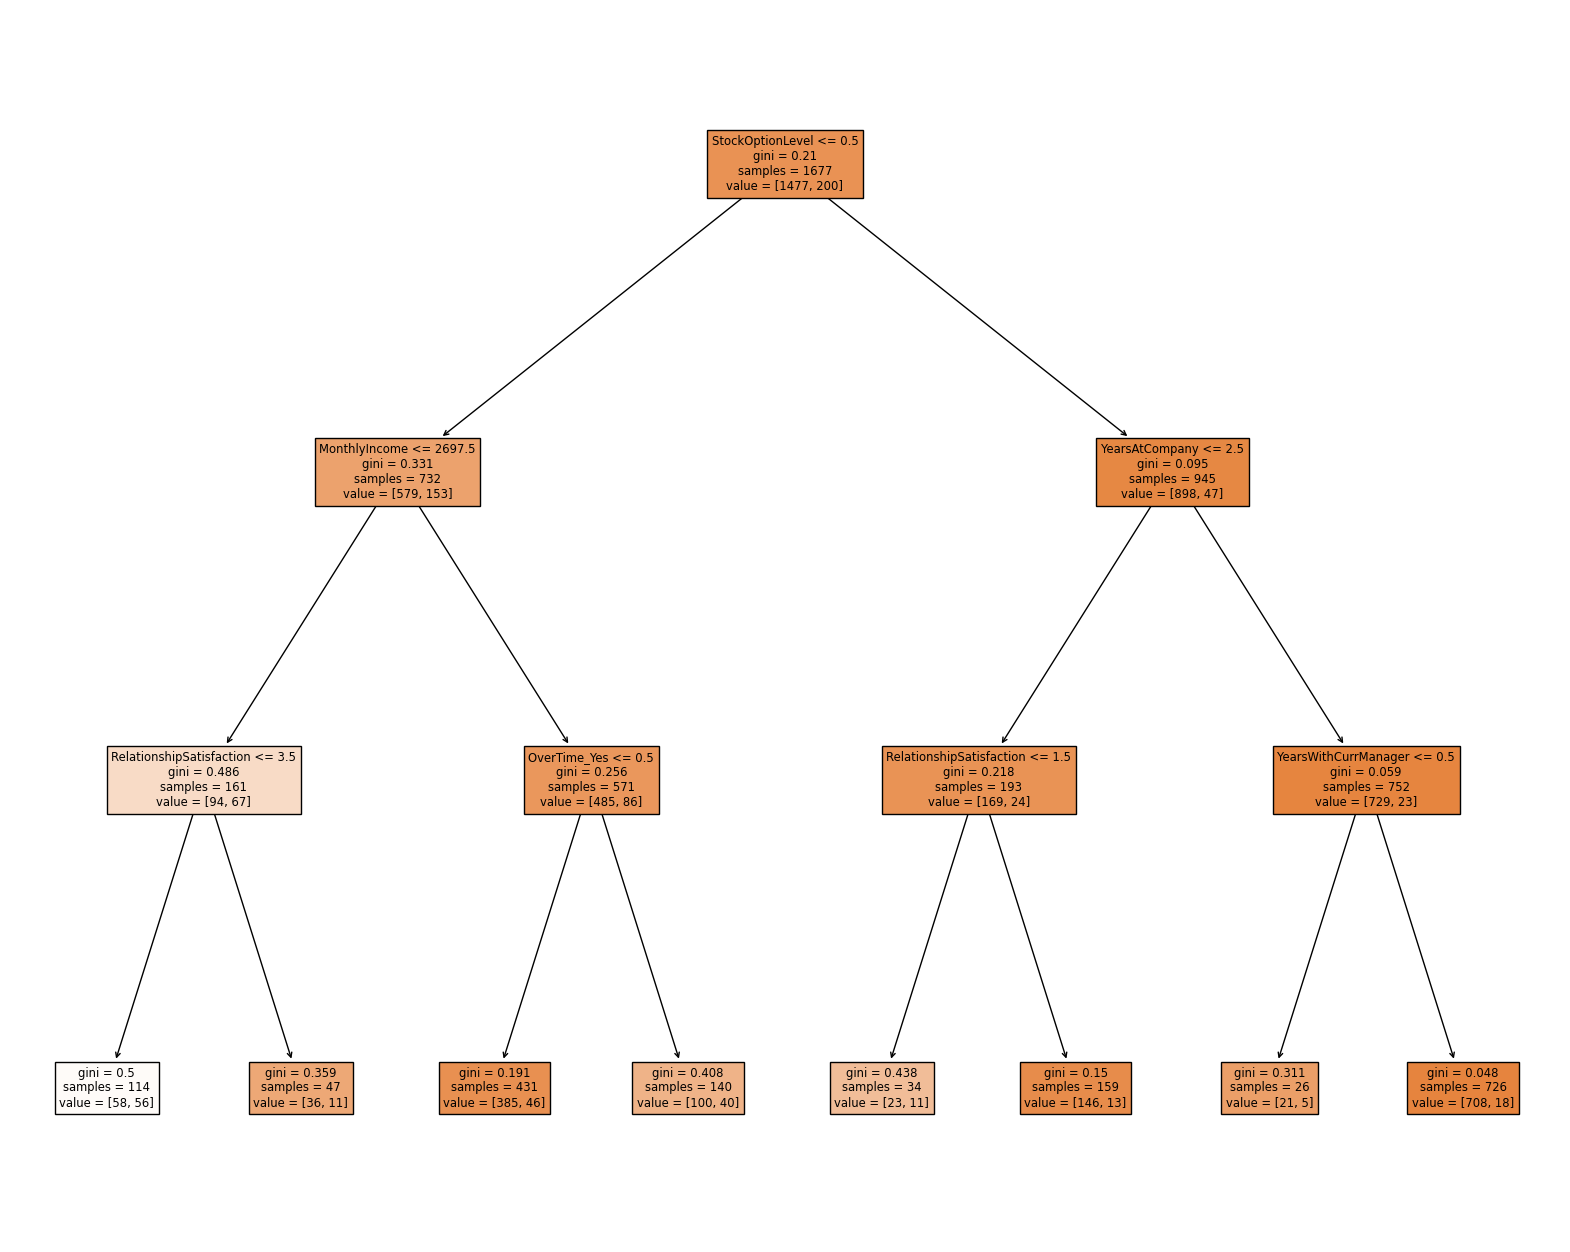

In [52]:
from sklearn.tree import DecisionTreeClassifier

train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']])
train_dummies = train_dummies.drop(columns = ['BusinessTravel_Non-Travel', 'Department_Research & Development', 'EducationField_Other', 'Gender_Female', 'JobRole_Manufacturing Director', 'MaritalStatus_Divorced', 'OverTime_No'])

X = train_RF.drop(columns = ['id', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Over18', 'StandardHours', 'Attrition'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['Attrition']

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X, Y)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True);

In [65]:
X['feature_1'] = np.where(((X['StockOptionLevel'] >= 1) & (X['YearsAtCompany'] >= 3) & (X['YearsWithCurrManager'] >= 1)), 1, 0)
X['feature_2'] = np.where(((X['StockOptionLevel'] < 1) & (X['MonthlyIncome'] > 2700) & (X['OverTime_Yes'] < 1)), 1, 0) 

In [64]:
X['OverTime_Yes']

0       1
1       0
2       0
3       0
4       1
       ..
1672    0
1673    0
1674    1
1675    0
1676    0
Name: OverTime_Yes, Length: 1677, dtype: uint8

In [57]:
X['YearsWithCurrManager'].value_counts()

2     387
0     298
7     265
3     174
8     126
4     107
1      71
9      57
5      37
6      34
11     30
10     29
12     22
13     17
17      8
14      7
15      6
16      2
Name: YearsWithCurrManager, dtype: int64

In [53]:
X['StockOptionLevel'].value_counts()

1    745
0    732
2    135
3     65
Name: StockOptionLevel, dtype: int64

In [56]:
X['YearsAtCompany'].value_counts()

5     228
1     214
3     176
10    138
4     121
2     108
7     103
9      99
8      91
6      87
0      54
20     35
11     28
13     28
15     27
22     17
16     16
14     16
12     14
17     14
21     13
24      9
19      8
18      7
33      5
25      5
31      4
29      3
34      2
27      2
30      2
26      1
37      1
41      1
Name: YearsAtCompany, dtype: int64